# What can we say about the temporal statistics of repeater bursts?
## Do these properties reflect the larger FRB population?

In [15]:
%matplotlib inline

In [16]:
import numpy as np
import pylab as pl
from astropy.stats import LombScargle
import astropy.time
import astropy.units as u
from scipy.stats import poisson

# for plotting lots of points
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

In [17]:
# program 15B-378
# 10 hours no detections
#obstimes_L = """"""

# programs 16A-459 and 16A-496
# 9 detections
obstimes_S = """
16-Apr-25 23:21:39, 16-Apr-26 03:21:00
16-Apr-26 23:14:31, 16-Apr-27 01:14:11
16-Apr-27 23:26:09, 16-Apr-28 01:25:50
16-Apr-28 22:41:31, 16-Apr-29 00:41:11
16-Apr-29 22:37:34, 16-Apr-30 00:37:14
16-Apr-30 19:14:46, 16-Apr-30 20:14:35
16-May-01 18:08:21, 16-May-01 19:08:10
16-May-02 23:14:18, 16-May-03 00:14:07
16-May-03 22:53:26, 16-May-03 23:53:15
16-May-04 22:50:30, 16-May-04 23:50:19
16-May-06 18:25:12, 16-May-06 19:25:01
16-May-07 19:34:13, 16-May-07 20:34:03
16-May-08 19:30:20, 16-May-08 20:30:10
16-May-13 17:12:48, 16-May-13 19:27:25
16-May-14 17:14:11, 16-May-14 19:28:48
16-May-15 17:15:26, 16-May-15 19:30:03
16-May-16 16:59:52, 16-May-16 19:14:29
16-May-20 16:45:46, 16-May-20 19:00:23
16-May-21 16:44:06, 16-May-21 18:58:44
16-May-22 16:43:53, 16-May-22 18:58:30
16-May-23 16:44:11, 16-May-23 18:58:48
16-May-27 16:29:34, 16-May-27 18:44:11
16-Aug-23 17:26:28, 16-Aug-23 18:20:18
16-Sep-02 15:52:17, 16-Sep-02 16:46:08
16-Sep-07 10:14:50, 16-Sep-07 12:14:29
16-Sep-08 10:14:40, 16-Sep-08 12:14:19
16-Sep-10 09:59:36, 16-Sep-10 11:59:15
16-Sep-11 09:59:49, 16-Sep-11 11:59:29
16-Sep-12 09:15:19, 16-Sep-12 11:14:58
16-Sep-13 09:23:59, 16-Sep-13 11:23:39
16-Sep-14 09:20:23, 16-Sep-14 11:20:03
16-Sep-15 09:16:29, 16-Sep-15 11:16:09
16-Sep-16 09:11:23, 16-Sep-16 11:11:03
16-Sep-17 08:59:20, 16-Sep-17 10:59:00
16-Sep-18 08:59:27, 16-Sep-18 10:59:07
16-Sep-19 08:44:32, 16-Sep-19 10:44:12
16-Sep-20 08:44:33, 16-Sep-20 10:44:13
"""

# end of 16A-496
# no detections
obstimes_C = """
16-Sep-20 17:19:03, 16-Sep-20 19:18:42
16-Sep-21 09:13:57, 16-Sep-21 11:13:36
16-Sep-22 09:12:24, 16-Sep-22 11:12:04
"""

In [18]:
ranges = []
for tr in obstimes_S.split('\n')[1:-1]:
    start, stop = tr.split(', ')
    start = start.replace('Apr', '04').replace('May', '05').replace('Aug', '08').replace('Sep', '09').replace('16-', '2016-')
    stop = stop.replace('Apr', '04').replace('May', '05').replace('Aug', '08').replace('Sep', '09').replace('16-', '2016-')
    starttime = astropy.time.Time(start, format='iso', scale='utc').mjd
    stoptime = astropy.time.Time(stop, format='iso', scale='utc').mjd
    ranges.append((starttime, stoptime))
    
tot = 0
start, stop = ranges[0]
times = np.linspace(start, stop, (stop-start)*24*3600)
for rr in ranges[1:]:
    start, stop = rr
    tot += 24*(stop - start)
    times = np.concatenate( (times, np.linspace(start, stop, (stop-start)*24*3600)), axis=0)

print('{0} hours in {1} observations'.format(tot, len(ranges)))
print('{0} time bins'.format(len(times)))

63.8683333336 hours in 37 observations
244264 time bins


In [19]:
eventtimes = [57623.74402686, 57633.67986367, 57633.695159375, 57638.49937435,
              57643.45730263, 57645.42958602, 57646.4660065, 57648.4369149, 57649.45175697]

In [20]:
values0 = np.zeros(len(times), dtype=bool)
for eventtime in eventtimes:
    bn = np.where(times > eventtime)[0]
    if len(bn) and bn[0] > 0:
        print(eventtime, bn[0])
        values0[bn[0]] = 1

(57623.74402686, 145972)
(57633.67986367, 149309)
(57633.695159375, 150629)
(57638.49937435, 157192)
(57643.45730263, 185845)
(57645.42958602, 197504)
(57646.4660065, 208063)
(57648.4369149, 220936)
(57649.45175697, 229390)


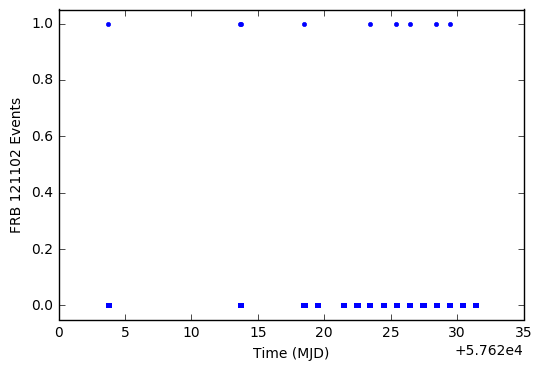

In [21]:
pl.plot(times[np.argwhere(times > 57600)], values0[np.argwhere(times > 57600)], '.')
pl.ylim(-0.05, 1.05)
pl.xlabel('Time (MJD)')
pl.ylabel('FRB 121102 Events')

## Lomb-Scargle analysis

In [22]:
def runls(times, values):
    ls = LombScargle(times, values)
    freq, power = ls.autopower()
    return freq, power

def plotls(freq, power):
    fig = pl.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    pl.plot(np.log10(freq), power, 'c')
    pl.xlabel('frequency (1/day)')
    pl.ylabel('power')
    pl.show()
    
def phaseit(times, values):
    ls = LombScargle(times, values)
    freq, power = ls.autopower()
    best_frequency = freq[np.argmax(power)]
    t_fit = np.linspace(0, 1)
    y_fit = ls.model(t_fit, best_frequency)
    phase = (times * best_frequency) % 1
    pl.plot(phase, values, '.')
    pl.ylim(-0.1, 1.1)

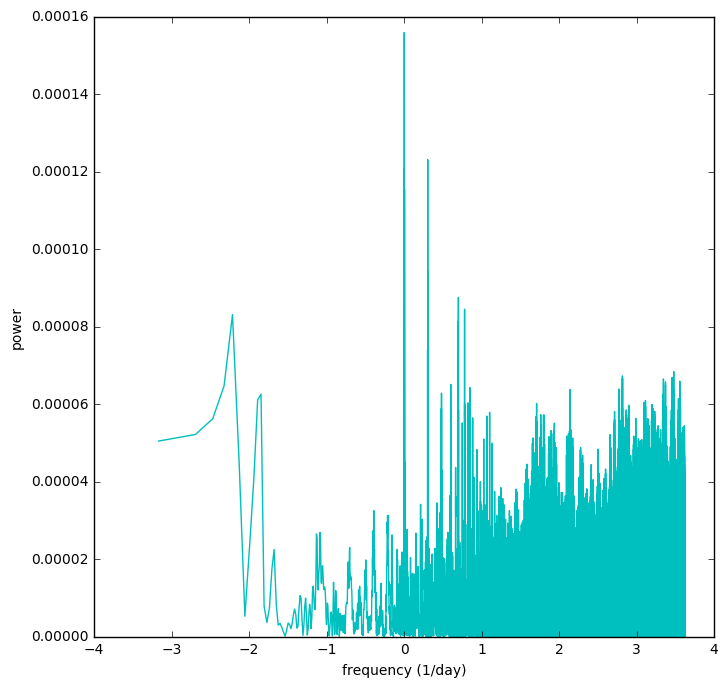

(3053300, 0.86939787051133044)


In [23]:
freq0, power0 = runls(times, values0)
plotls(freq0, power0)
print(len(freq0), 3600./freq0.max())

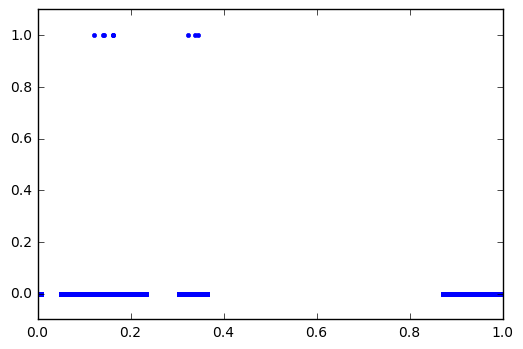

In [24]:
phaseit(times, values0)

## simulate Lomb-Scargle to find effect of observing cadence

In [25]:
freqs = []
powers = []
for trial in range(100):
    values = np.zeros(len(times), dtype=bool)
    ets = np.random.choice(times[np.where(times > 57600)], size=9, replace=False)  # only last campaign
#    ets = np.random.choice(times, size=9, replace=False)  # all times
    for et in ets:
        etind = np.where(times >= et)[0][0]
        values[etind] = 1
        
#    pl.plot(times, values, '.')
#    pl.ylim(-0.1, 1.1)
    freq, power = runls(times, values)
#    plotls(freq, power)
    powers.append(power)
    
powers = np.array(powers)

In [26]:
powsort = np.sort(powers, axis=0)
pow5 = powsort[5]
pow95 = powsort[95]

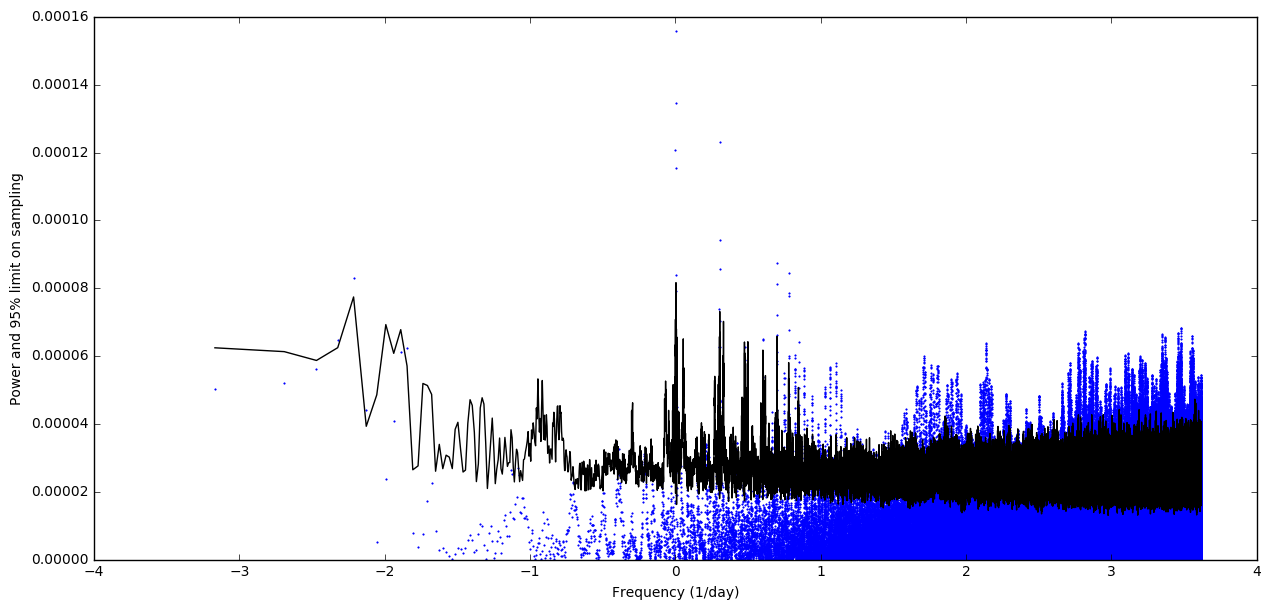

In [27]:
pl.figure(figsize=(15,7))
pl.plot(np.log10(freq), power0, '.', markersize=2)
#pl.plot(np.log10(freq), pow5, 'k-', linewidth=1)
pl.plot(np.log10(freq), pow95, 'k-', linewidth=1)
#pl.plot(freq, power0, '.', markersize=2)
#pl.plot(freq, pow5, 'k-', linewidth=1)
#pl.plot(freq, pow95, 'k-', linewidth=1)
#pl.xlim(4, 6)
pl.xlabel('Frequency (1/day)')
pl.ylabel('Power and 95% limit on sampling')

## Rate

In [28]:
# is the rate dropping in time?
sel = np.where((times > 57600) & (times < 57635))
print(values0[sel].mean()*3600)
sel = np.where((times > 57635) & (times < 57660))
print(values0[sel].mean()*3600)

1.67182662539
0.231441796674


In [29]:
t0 = 57623.
rate = lambda t, a, b: a+b*(t-t0)
rprod = lambda t, v, a, b: np.prod(poisson.pmf(v, np.maximum(rate(t, a, b), 0.)))

In [30]:
ar = np.linspace(1e-5, 7.5e-4, 70)
br = np.linspace(-2.8e-5, 0.5e-5, 50)
sel = np.where((times > t0))
probs = np.zeros(shape=(len(ar), len(br)))

In [31]:
for i in range(len(ar)):
    for j in range(len(br)):
        probs[i,j] = rprod(times[sel], values0[sel], ar[i], br[j])
probs = np.ma.masked_invalid(probs)

(29, 24, 1.9679335601238362e-40)


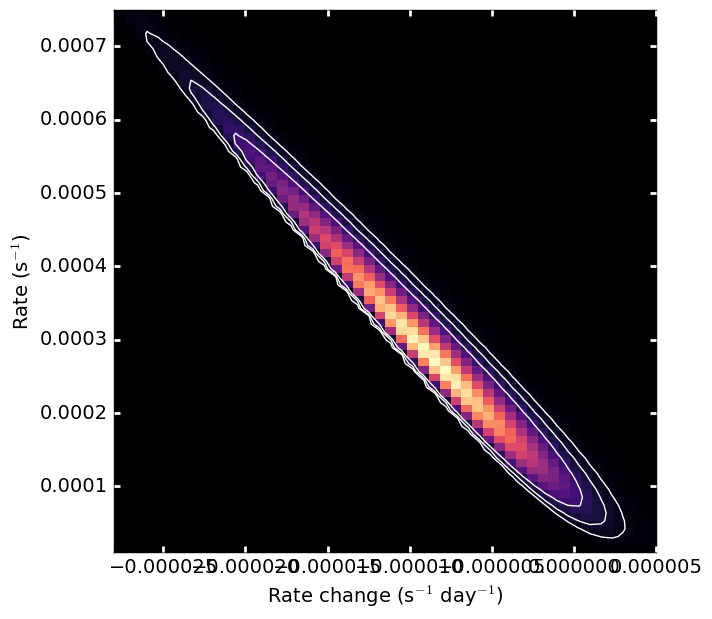

In [32]:
fig = pl.figure(figsize=(7,7))
ax = fig.add_subplot(111)
pl.imshow(probs/probs.max(), interpolation='nearest', aspect='auto', origin='bottom', cmap='magma',
          extent=(br[0], br[-1], ar[0], ar[-1]))
X, Y = np.meshgrid(br, ar)
pl.contour(X, Y, probs/probs.max(), [0.05, 0.1, 0.2], colors='w')
#pl.contour(probs/probs.max(), [0.05])
pl.xlabel('Rate change (s$^{-1}$ day$^{-1}$)', fontsize=14)
pl.ylabel('Rate (s$^{-1}$)', fontsize=14)
xt = pl.setp(ax.get_xticklabels(), fontsize=14)
yt = pl.setp(ax.get_yticklabels(), fontsize=14)
ax.xaxis.set_tick_params(width=2, color='w')
ax.yaxis.set_tick_params(width=2, color='w')
#pl.colorbar()

bm, am = np.where(probs == probs.max())
print(am[0], bm[0], probs[bm, am].data[0])